## Introduction
In this demo, we will analyze single-cell RNA-seq data using Python on Google Colab platform


## Download data and install required library
Data contain 3,000 peripheral blood mononulcear cells (PBMCs) from a healthy donor (provided by 10x Genomics)

In [ ]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

--2022-09-29 07:01:44--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2022-09-29 07:01:44--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  --.-KB/s    in 0.1s    

2022-09-29 07:01:44 (70.5 MB/s) - ‘data/pbmc3k_filtered_gene_bc_matri

In [ ]:
!ls -la 'drive/MyDrive/Courses Content/RNAseq_Workshop_Jan2022'

total 15
-rw------- 1 root root  283 Sep 19 07:26 metadata.txt
drwx------ 2 root root 4096 Sep 24 11:38 mov10_data
drwx------ 2 root root 4096 Sep 21 09:42 outputs
-rw------- 1 root root  449 Sep 19 07:52 run_kallisto.bat
-rw------- 1 root root 1654 Sep 19 07:56 run_sleuth.R
drwx------ 2 root root 4096 Jan  6  2022 yeast_data


Google cloud environment does not have some required libary, so we have to install them

Once the installation finished, you have to restart the environment to use the new library (There should be a *RESTART RUNTIME* button at the end of the output)

Then you need to rerun these *import* commands again

In [ ]:
!pip install scanpy leidenalg bbknn

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import single-cell data
Variables are gene symbols

In [ ]:
adata = sc.read_10x_mtx('data/filtered_gene_bc_matrices/hg19/',
                        var_names = 'gene_symbols',
                        cache = True)

adata.var_names_make_unique() ## ensure that all gene symbols are unique
print(adata)

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


Visualize highly expressed genes

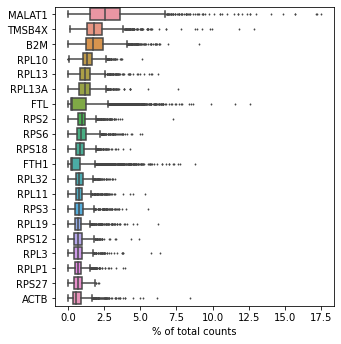

In [ ]:
sc.pl.highest_expr_genes(adata, n_top = 20, )

## Quality filter
* Each cell must express at least 200 genes
* Each gene must be observed in at least 3 cells

In [ ]:
sc.pp.filter_cells(adata, min_genes = 200)
sc.pp.filter_genes(adata, min_cells = 3)

Analyze proportion of *mitochondrial* gene expression (gene symbols beginning with *MT-*)

Remove cell with above 5% mitochondrial expression

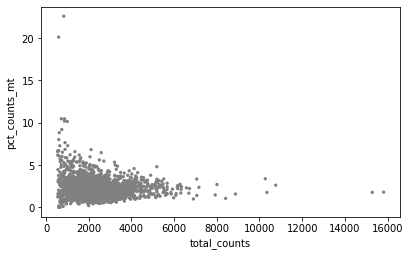

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt'], percent_top = None, log1p = False, inplace = True)

sc.pl.scatter(adata, x = 'total_counts', y = 'pct_counts_mt')
adata = adata[adata.obs.pct_counts_mt < 5, :]

Remove cells with more than 2,500 genes detected (possibly multi-cells)

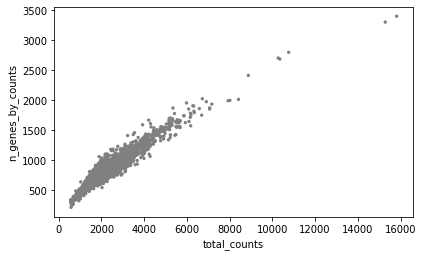

In [ ]:
sc.pl.scatter(adata, x = 'total_counts', y = 'n_genes_by_counts')
adata = adata[adata.obs.n_genes_by_counts < 2500, :]

## Data normalization and preprocessing
* Scale total read counts to 10,000 reads for each cell
* Log-transform read counts


In [ ]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Identify highly variable genes (high variance across cells) as they likely are cell type-specifics markers

Note the impact of data normalization (left panel) compared to raw data (right panel)

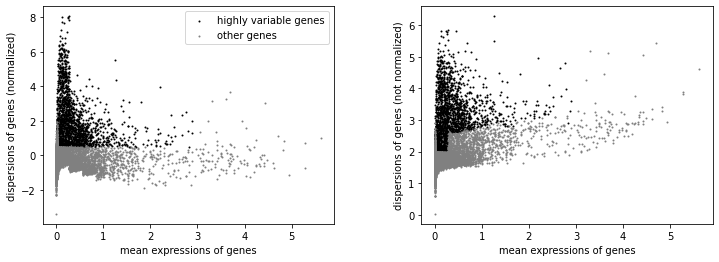

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)
sc.pl.highly_variable_genes(adata)

adata.raw = adata
adata = adata[:, adata.var.highly_variable]

Remove biases from sequencing depth and mitochondrial expression (linear effect model)

*Regress out* = use regression to identity the effect sizes and them subtracting them from the expression data

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

## Visualize data on 2D
First, using Principal Component Analysis (PCA, linear dimensionality reduction)

Labeling with [*CST3*](https://www.genecards.org/cgi-bin/carddisp.pl?gene=CST3) expression levels show that the cells are well-ordered 

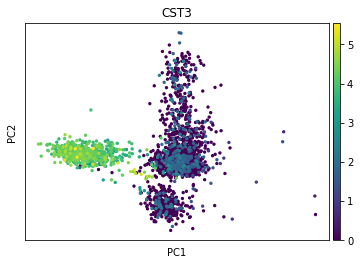

In [ ]:
sc.pp.scale(adata, max_value = 10)
sc.tl.pca(adata, svd_solver = 'arpack')
sc.pl.pca(adata, color = 'CST3')

Multi-step dimensionality reduction
* Perform PCA (linear dimensionality reduction)
* Compute *neighbor network* using only the first 40 dimensions from PCA
* Cluster cells using *leiden* algorithm
* Perform UMAP (non-linear dimensionality reduction)

Labeling with CST3, [NKG7](https://www.genecards.org/cgi-bin/carddisp.pl?gene=NKG7), and [PPBP](https://www.genecards.org/cgi-bin/carddisp.pl?gene=PPBP) expression levels show that each cell cluster on UMAP is associated with some gene markers

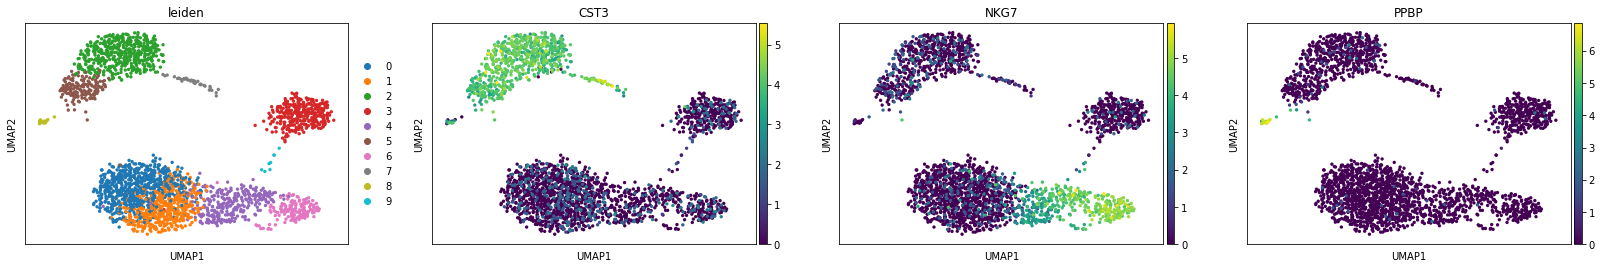

In [ ]:
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs = 40)
sc.tl.leiden(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot = False)
sc.tl.umap(adata, init_pos = 'paga')
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7', 'PPBP'])

## Finding marker genes
For each cluster identified, perform differential expression between that cluster versus the result of the cell using *Wilcoxon*

Show the top 25 genes along with their scores (*Wilcoxon* test statistics)

* CST3 shows up as a marker for cluster 1
* NKG7 shows up as a marker for clusters 4 and 5
* PPBP shows up as a marker for cluster 10

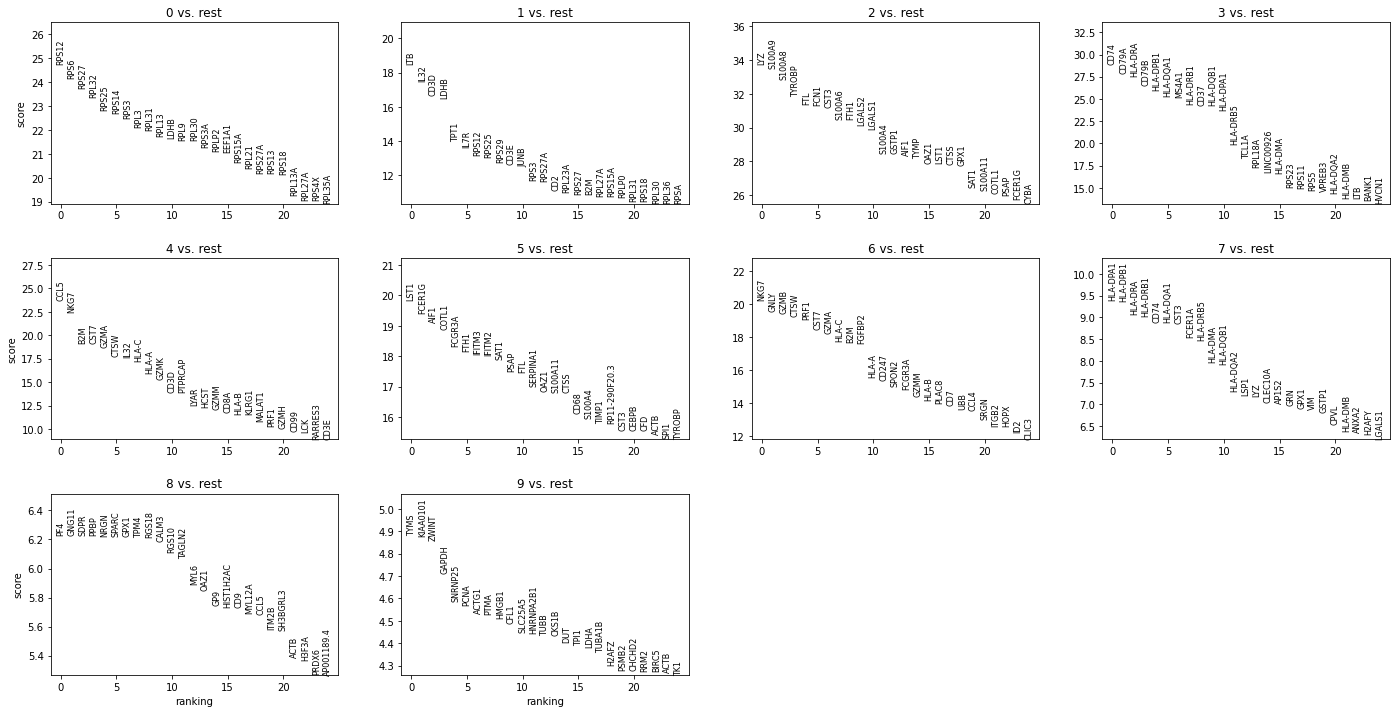

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method = 'wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes = 25, sharey = False)

View the expression of top 8 marker genes for cluster 1

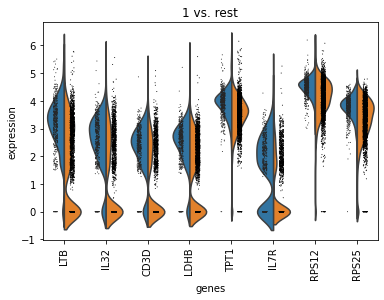

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups = '1', n_genes = 8)

Compare gene expression across clusters

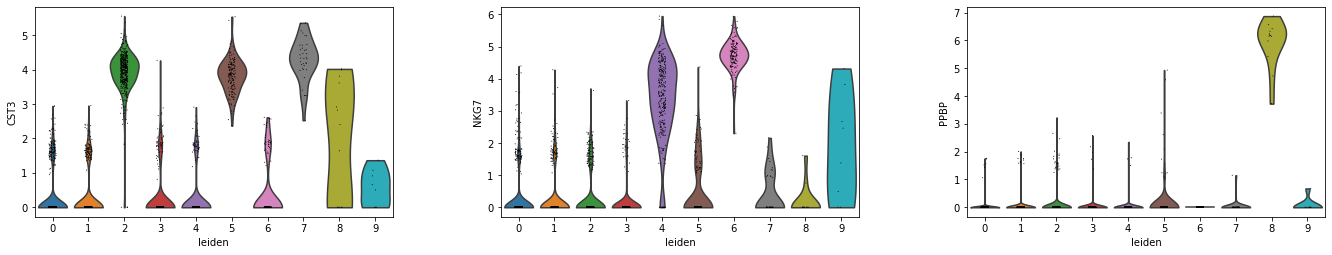

In [ ]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby = 'leiden')

Summarize marker genes using *dot plot*
* Color indicates expression level
* Circle size indicates % of cell expressing that marker

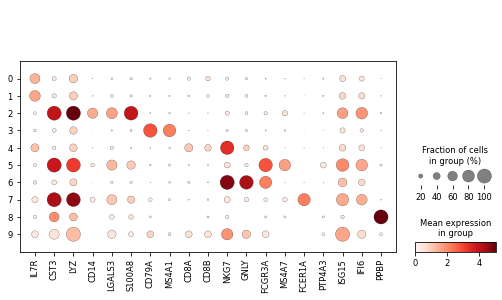

In [ ]:
marker_genes = ['IL7R', 'CST3', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'CD79A', 'MS4A1', 
                'CD8A', 'CD8B', 'NKG7', 'GNLY', 
                'FCGR3A', 'MS4A7', 'FCER1A', 'PTP4A3',
                'ISG15', 'IFI6', 'PPBP']

sc.pl.dotplot(adata, marker_genes, groupby = 'leiden', vmax = 5);

## Data integration
We will combine two PBMC datasets

In [ ]:
adata_ref = sc.datasets.pbmc3k_processed()  # This is an annotated version of the PBMC dataset above
adata = sc.datasets.pbmc68k_reduced()

  0%|          | 0.00/23.5M [00:00<?, ?B/s]

Identify overlapping gene sets

In [ ]:
var_names = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]

Visualize data before integration using UMAP

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


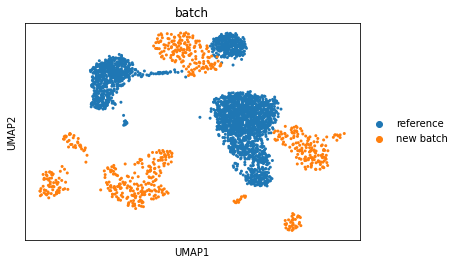

In [ ]:
adata_concat = adata_ref.concatenate(adata, batch_categories = ['reference', 'new batch'])
sc.pl.umap(adata_concat, color=['batch'])

Perform dimensionality reduction and clustering on the reference dataset (same as earlier)

In [ ]:
sc.tl.pca(adata_ref, svd_solver = 'arpack')
sc.pp.neighbors(adata_ref, n_neighbors = 10, n_pcs = 40)
sc.tl.leiden(adata_ref)
sc.tl.paga(adata_ref)
sc.pl.paga(adata_ref, plot = False)
sc.tl.umap(adata_ref, init_pos = 'paga')

### One-way mapping

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


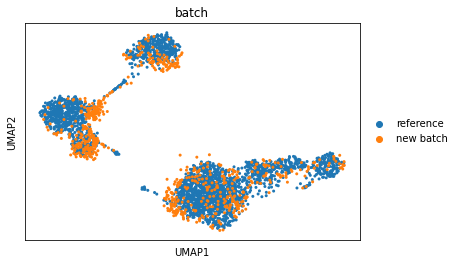

In [ ]:
sc.tl.ingest(adata, adata_ref, obs = 'leiden')
adata_concat = adata_ref.concatenate(adata, batch_categories = ['reference', 'new batch'])
sc.pl.umap(adata_concat, color=['batch'])

### Mutual nearest neighbor

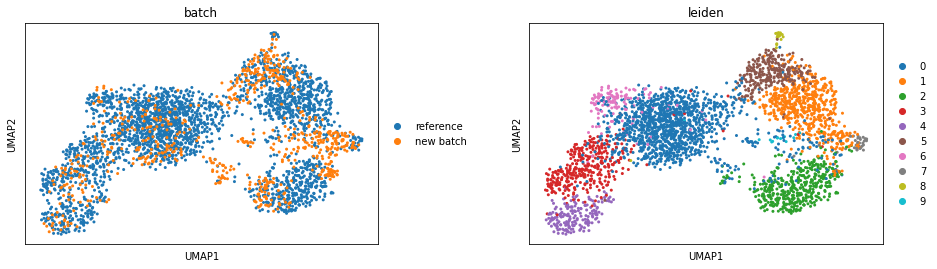

In [ ]:
sc.tl.pca(adata_concat)
sc.external.pp.bbknn(adata_concat, batch_key = 'batch')
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color = ['batch', 'leiden'], wspace = 0.3)

## Another data integration example
Pancreas tissue sample with 14,693 cells

In [ ]:
adata_all = sc.read('data/pancreas.h5ad', backup_url='https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1')
print('number of cells:', adata_all.shape[0])

  0%|          | 0.00/176M [00:00<?, ?B/s]

number of cells: 14693


/usr/local/lib/python3.7/dist-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


Remove minority cell types

In [ ]:
counts = adata_all.obs.celltype.value_counts()
counts

alpha                     4214
beta                      3354
ductal                    1804
acinar                    1368
not applicable            1154
delta                      917
gamma                      571
endothelial                289
activated_stellate         284
dropped                    178
quiescent_stellate         173
mesenchymal                 80
macrophage                  55
PSC                         54
unclassified endocrine      41
co-expression               39
mast                        32
epsilon                     28
mesenchyme                  27
schwann                     13
t_cell                       7
MHC class II                 5
unclear                      4
unclassified                 2
Name: celltype, dtype: int64

In [ ]:
minority_classes = counts.index[-10:].tolist()
minority_classes.append('not applicable')

adata_all = adata_all[~adata_all.obs.celltype.isin(minority_classes)]

Before integration

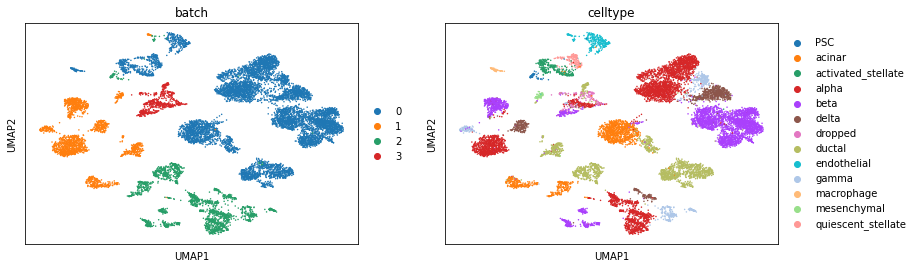

In [ ]:
sc.pp.pca(adata_all)
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_all)
sc.pl.umap(adata_all, color = ['batch', 'celltype'], palette = sc.pl.palettes.vega_20_scanpy)

Integration using mutual nearest neighbor

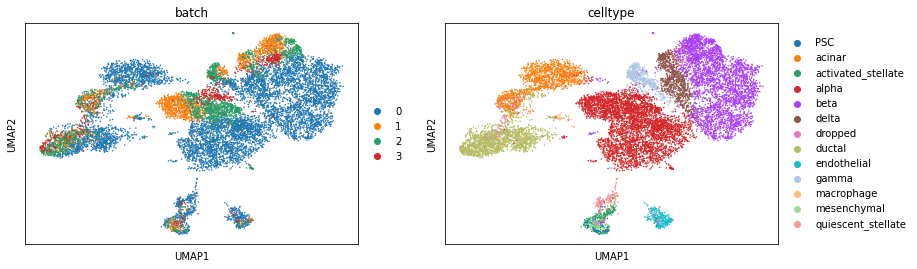

In [ ]:
sc.external.pp.bbknn(adata_all, batch_key = 'batch')
sc.tl.umap(adata_all)
sc.pl.umap(adata_all, color = ['batch', 'celltype'])

Visualize distribution of batches

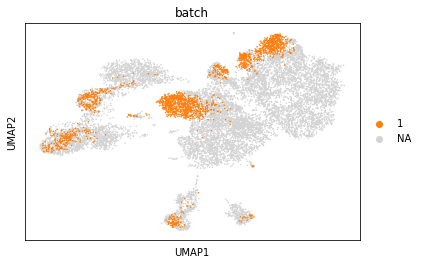

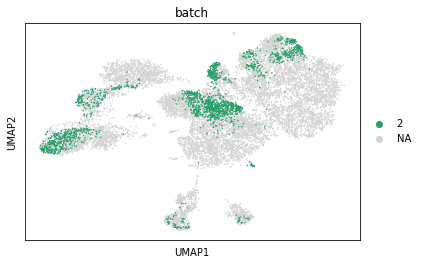

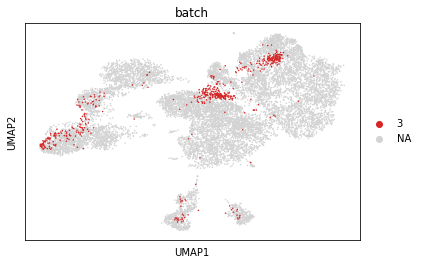

In [ ]:
for batch in ['1', '2', '3']:
    sc.pl.umap(adata_all, color = 'batch', groups = [batch])

## Trajectory inference
2,700 cells from myeloid and erythroid differentiation

Use *diffusion* map to calculate transition probabilities between cells

  0%|          | 0.00/9.82M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/usr/lib/python3.7/contextlib.py:119: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


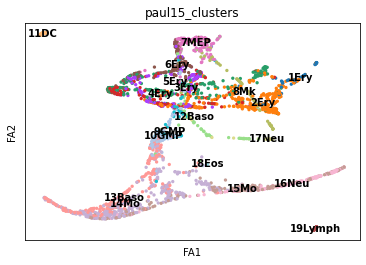

In [ ]:
adata = sc.datasets.paul15()

sc.pp.recipe_zheng17(adata)
sc.tl.pca(adata, svd_solver = 'arpack')
sc.pp.neighbors(adata, n_neighbors = 4, n_pcs = 20)
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors = 10, use_rep = 'X_diffmap')

sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color = 'paul15_clusters', legend_loc = 'on data')

### Cluster-level trajectory
Reconstruct cluster-to-cluster trajectory outline using [PAGA](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1663-x) algorithm

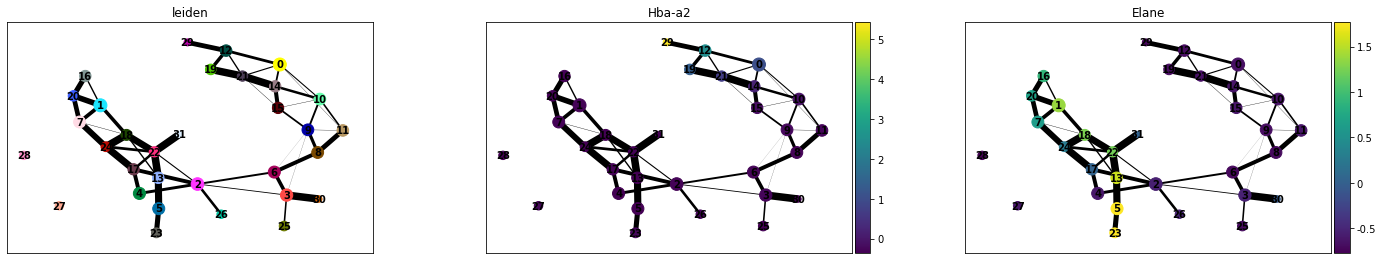

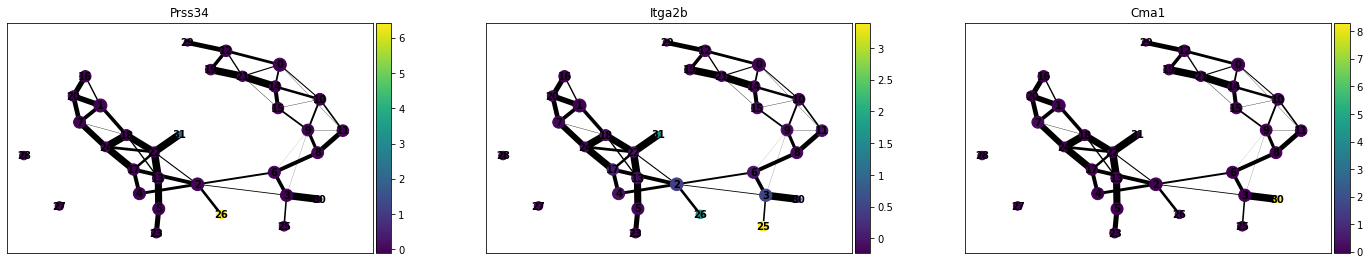

In [ ]:
sc.tl.leiden(adata, resolution = 1.0)
sc.tl.paga(adata, groups = 'leiden')
sc.pl.paga(adata, color = ['leiden', 'Hba-a2', 'Elane'])
sc.pl.paga(adata, color=['Prss34', 'Itga2b', 'Cma1'])

### Cell-level trajectory
Use cluster-level connectivity as a template for placing individual cells

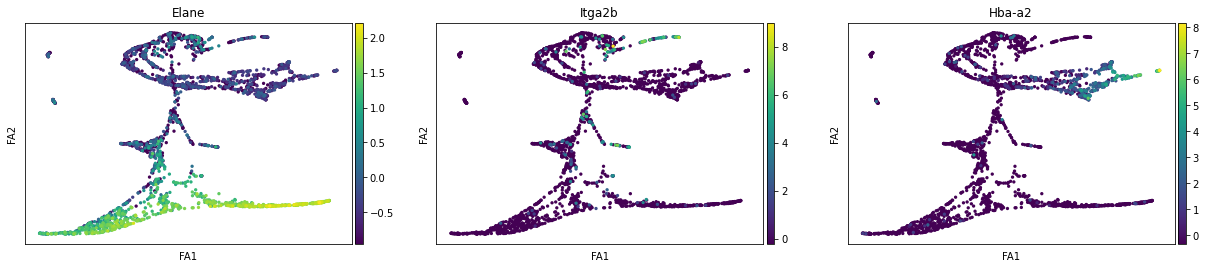

In [ ]:
sc.tl.draw_graph(adata, init_pos = 'paga')
sc.pl.draw_graph(adata, color = ['Elane', 'Itga2b', 'Hba-a2'])

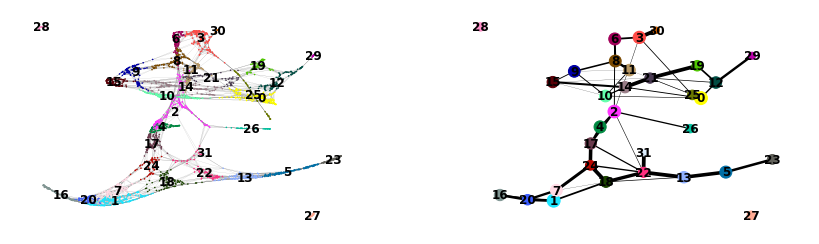

In [ ]:
sc.pl.paga_compare(
    adata, threshold = 0.03, title='', right_margin = 0.2, size = 10, edge_width_scale = 0.5,
    legend_fontsize = 12, fontsize = 12, frameon = False, edges = True)

### Estimate pseudotime
Use annotated stem cells as the origin (leiden cluster 2)

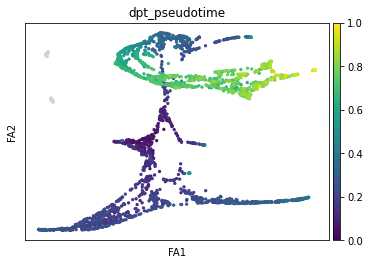

In [ ]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['leiden']  == '2')[0]
sc.tl.dpt(adata)
sc.pl.draw_graph(adata, color = ['dpt_pseudotime'])

Diffusion map simplifies the developmental trajectory as one straight line

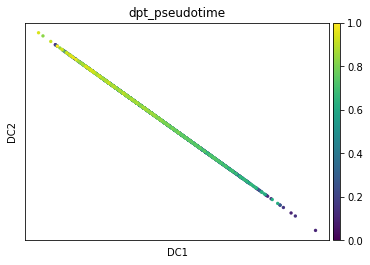

In [ ]:
sc.pl.diffmap(adata[~np.isinf(adata.obs['dpt_pseudotime']), :], color = 'dpt_pseudotime')